In [ ]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
from scipy.signal import convolve2d

In [ ]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.6.13
Numpy version:  1.18.5


## Section A: Change Detection

**A1. Simple change detection**

Compute a simple change detection algorithm. Use as background the median of a set of k1 frames, and update it every k2 frames. Your algorithm should work on color images. Think how to merge the different channels (colors). You can assume that the camera is static. The output is a video where the pixels of the  foreground objects consists of the original frame, and the other pixels are black. 

*Input:* video, k1, k2, and any other parameter you would like to add\
im: a grey level or an RGB image\
k1: the number of frames for computing the median\
k2: the number of frames between two updates of the background

*output:*  v_foreground

In [ ]:
FOLDER = 'DATA1'
FOLDER2 = 'DATA2'
VIDEO =  'SLIDE.avi'
video_file_name = '{}/{}'.format(FOLDER, VIDEO)

moving_camera_file ='{}/horses.avi'.format(FOLDER2)
video_file_name, moving_camera_file


('DATA1/SLIDE.avi', 'DATA2/horses.avi')

In [ ]:
def plot_images(img1, name1, img2, name2):
    
    plt.rcParams['figure.figsize'] = (16, 16) 
    f, ((ax1, ax2)) = plt.subplots(1, 2)

    ax1.imshow(img1, cmap='gray'), ax1.set_title(name1)
    ax2.imshow(img2, cmap='gray'), ax2.set_title(name2)

def get_video_images(video_file_name, is_color=False):
    video_images = []
    video = cv2.VideoCapture(video_file_name)
    success, image = video.read()
    
    while success:
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if is_color else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        video_images.append(image)
        success, image = video.read()
    
    return video_images


In [ ]:
def get_background_img(images_list):
    
    background_image = np.zeros_like(images_list[0])
    
    pixels_sums = np.sum(images_list, axis=(3))
    
    for i in range(background_image.shape[0]):
        for j in range(background_image.shape[1]):
            
            pixel_sum_all_images = pixels_sums[:, i, j]
            pixel_sum_all_images = [(i, val) for (i,val) in enumerate(pixel_sum_all_images)]
            pixel_sum_all_images = sorted(pixel_sum_all_images, key = lambda index_val_pair: index_val_pair[1])
            median_pixel_index = pixel_sum_all_images[int(len(pixel_sum_all_images)/2)][0]
            
            background_image[i][j] = images_list[median_pixel_index][i][j]
            

    return background_image
    
def median_change_dection(name_file, k1, k2, threshold):
    
    v_foreground = get_video_images(name_file, is_color=True)
    v_origin = get_video_images(name_file, is_color=True)
    images_list_2 = v_foreground #np.array(v_foreground)

    count = 0 
    for ix, img in enumerate(v_foreground):
        
        if ix % k2 == 0: # update background_img
            background_img = get_background_img(images_list_2[ix : k1 + ix])
        
        distances = cv2.subtract(img, background_img)
        result = cv2.threshold(distances, threshold, 1, cv2.THRESH_BINARY)[1]  # binary_mask
        
        
        results_less_than2_indexes = np.where(np.sum(result, axis=2) < 2)
        img[results_less_than2_indexes] = [0, 0, 0]
        
        

    return  v_origin, np.array(v_foreground)


In [ ]:
k1 = 25
k2 = 25
threshold= 35

v_origin, v_foreground = median_change_dection(video_file_name, k1=k1, k2=k2, threshold=threshold)

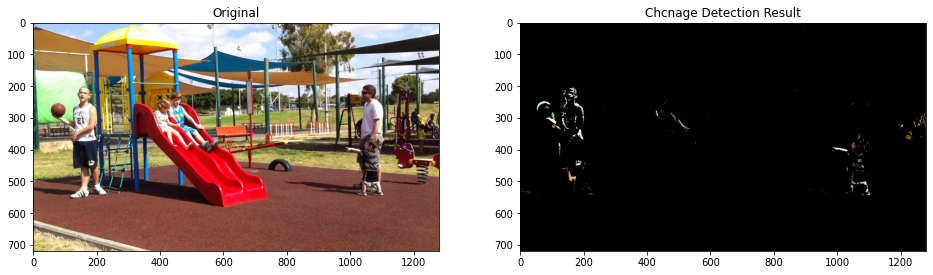

In [ ]:
plot_images(v_origin[10],  "Original", v_foreground[10], "Chcnage Detection Result")    

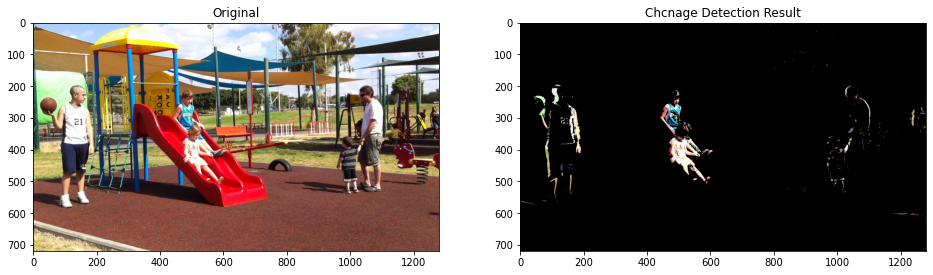

In [ ]:
plot_images(v_origin[55],  "Original", v_foreground[55], "Chcnage Detection Result")    

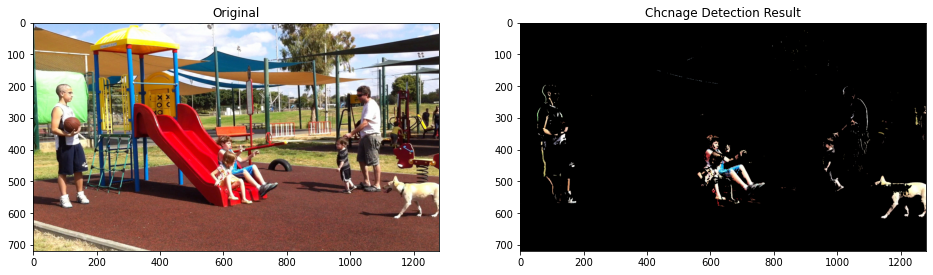

In [ ]:
plot_images(v_origin[80],  "Original", v_foreground[80], "Chcnage Detection Result")    

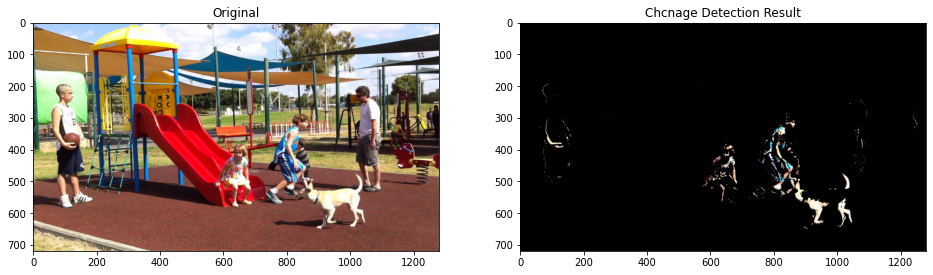

In [ ]:
plot_images(v_origin[105],  "Original", v_foreground[105], "Chcnage Detection Result")    

**A2. Post Processing for change detection**

**Answer:** Suggest a post processing algorithm for improving  the results of a change detection algorithm (e.g., remove noise or fill gaps). 

**Code:** implement your algorithm.

*Input:*  v_original, v_foreground\
v_original: the original video\
v_foreground: the output of A1

*output:* v_PP_foreground\
v_PP_foreground: the result of the post processing on v_foreground.


**Note:**
1. You may want to generate from v_foreground  a binary mask of the foreground regions.
2. You can use dilation or erosion on a the binary mask.
3.  You may use additional frames to improve the results, but you do not have to.



<b><b><b>
To remove noises:
    
for every frames in the v_foreground we can create binary mask
where foreground pixels are 1 and other pixels are zero.
then we can calculate connected components and remove small connected components.

<b><b><b>
To fill gaps:

than we can update the binaty mask and use convolution to find background pixels which are close
to foreground pixels and set them to be dilate pixels.
than use the added pixels intencity values from the original image. 


In [ ]:
def improve_frame(original_image, image, cc_threshold, conv_threshold = 1):
    
    improved_image = np.array(image, copy=True)
    
    labels, connected_mat = cv2.connectedComponents(image[:, :, 0], connectivity=8)
        
    unique, counts = np.unique(connected_mat, return_counts=True)
    
    for i in range(connected_mat.shape[0]):
        
        for j in range(connected_mat.shape[1]):
            
            current_component = connected_mat[i][j]
            
            if current_component == 0:
                continue
                
            elif  counts[current_component] < cc_threshold:
                improved_image[i][j]= [0, 0, 0]
            
    
    conv_res = convolve2d(improved_image[:, :, 0], np.ones((40 ,40)), mode = 'same')
    
    rows_columns = np.where(conv_res >= conv_threshold)
    
    
    improved_image[rows_columns] = original_image[rows_columns]
    
    return improved_image


def improve_foreground(v_original, v_foreground, threshold, conv_threshold = 1):
    
    improved_frames = list()
    for (image_index, image) in enumerate(v_foreground):
                        
        improved_frame = improve_frame(v_original[image_index], image, threshold, conv_threshold)
        improved_frames.append(improved_frame)
        
    return v_original, improved_frames




In [ ]:
v_original, v_PP_foreground = improve_foreground(v_origin, v_foreground, 10, 100)

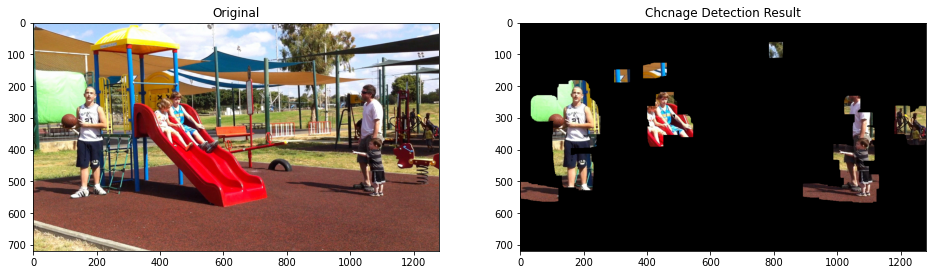

In [ ]:
plot_images(v_origin[0],  "Original", v_PP_foreground[0], "Chcnage Detection Result") 

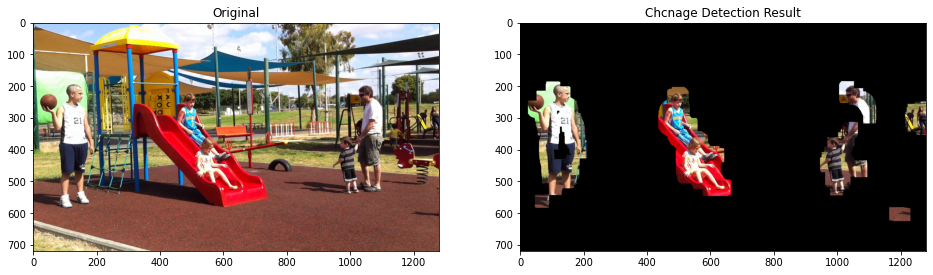

In [ ]:
plot_images(v_origin[60],  "Original", v_PP_foreground[60], "Chcnage Detection Result") 

# Section B: Compute Optical Flow (OF) using Lucas-Kanade

**B1. Basic Lucas Kanade OF**

Impelment the basic Lucas-Kanade we leared in class.

*Input:*  name_file, nf1, nf2,  region_size, sigma_S\
name_file: a name of a video file\
f1 and f2: the numbers of the two frames form the video on which the OF is computed.\
sigma_S: the variance of the Gaussian used for the  spatial smoothing  as in HW1 (for computing the derivative of a Gaussian).\
region_size, $R$: the $R\times R$ the region windows for computing the matrix $C$ (see class 7, slide 58).

*Output:* U, V, im1,im2\
U, V:  two matrices with the x and y motion for each pixel, respectively.\
im1, im2: the frames on which the optical flow was computed (their number in the video is nf1 and nf2).

**Note:**
1. You can use any video reading method you find convenient.
2. Do not forget to convert the images into grey scale.
3. You can compute the derivatives of the images as in HW1 - convolution with the derivative of a Gaussian.
3. You can resize the images in order for the program to run faster.
5. The computed OF is not necessarily integers. You may want to perform float computation.

In [ ]:
def Deriv_Gauss_xy(sigma, size):
    
    if (size % 2) == 0:
        size += 1
        
    ax = np.linspace(-(size-1)/2,(size-1)/2,int(size))
    x, y = np.meshgrid(ax,ax)
    G_dx = ((-x)/2*np.pi*sigma**4)*np.exp(-(np.square(x)+np.square(y))/(2*sigma**2))
    G_dy = ((-y)/2*np.pi*sigma**4)*np.exp(-(np.square(x)+np.square(y))/(2*sigma**2))
    
    return G_dx,G_dy


def gaussian(x, y, sigma):
    return np.exp(-0.5 * (np.square(x) + np.square(y)) / np.square(sigma))


def gaussian_derivative(axis, x, y, sigma):
    axis_parameter = x if axis == 'x' else y
    return (-axis_parameter/2*np.pi*sigma**4)*np.exp(-(np.square(x) + np.square(y))/(2*sigma**2))



def get_gaussian_kernel(sigma=1., mask_size=5, axis='x', kernel_mode=''):
    
    mask_size = int(mask_size)
    
    if (mask_size % 2) == 0:
        mask_size += 1
        
    ax = np.linspace(-(mask_size - 1) / 2., (mask_size - 1) / 2., mask_size)
    xx, yy = np.meshgrid(ax, ax)

    if kernel_mode == 'der':
        kernel = gaussian_derivative(axis, xx, yy, sigma)
    else:
        kernel =  gaussian(xx, yy, sigma)

    return kernel / np.sum(kernel)
   

In [ ]:
def build_uv(fx, fy, ft, window_size, threshold = 0.05):

    pad = int(window_size/2)
    u = np.zeros(fx.shape)
    v = np.zeros(fx.shape)

    for i in range(pad, fx.shape[0] - pad):
        for j in range(pad, fx.shape[1] -pad):
            
            x = fx[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten()
            y = fy[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten()
            t = ft[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten()
            A = np.vstack((x, y)).T
            b = np.reshape(t, (t.shape[0], 1))
            C = np.matmul(A.T, A)

            if np.linalg.matrix_rank(C, threshold) >= 2:
                
                mul_res = np.matmul(np.linalg.pinv(A), b)
                u[i, j] = mul_res[0]
                v[i, j] = mul_res[1]

    return u, v

def LK_OF(name_file, nf1, nf2, sigma_S, sigma_R):
        
    images = get_video_images(name_file)
    
    image1 = images[nf1]
    image2 = images[nf2]
    
    mask_x, mask_y = Deriv_Gauss_xy(sigma_S, sigma_S * 4)
    
    mask_t = np.ones((2,2))
    
    fx = convolve2d(image1,  mask_x, mode = 'same') 
    fy = convolve2d(image1,  mask_y, mode = 'same')
    ft = convolve2d(image2,  mask_t, mode = 'same') - convolve2d(image1, mask_t, mode = 'same')  
    
    U, V = build_uv(fx, fy, ft, 43)
    
    return [U, V, image1, image2]

    


In [ ]:
U, V, im1, im2 = LK_OF(video_file_name, 50, 52, 1.0, 1.0)

**B2. Present OF results**

*Input:* im1, U, V (the output of LK_OF without im2).

*Output:* a quiver plot overlaid the input frame

**Note:**
1. You can look at https://pythonforundergradengineers.com/quiver-plot-with-matplotlib-and-jupyter-notebooks.html
2. You may want for visualaization to uniformally resize the values of U and V - if they are too large or too small.
2. You may not want to draw the OF  each pixel - to avoid OF overlapping of neighboring pixels.

In [ ]:
def OF_plot_results(U,V,im1):
    
    skip = 20
        
    xs = U[::skip, ::skip] 
    ys = V[::skip, ::skip]
    
    y = np.arange(0, im1.shape[0], 1.0)
    x = np.arange(0, im1.shape[1], 1.0)
    
    xv, yv = np.meshgrid(x, y)
    
    xv = xv[::skip, ::skip]
    yv = yv[::skip, ::skip]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(im1, cmap='gray')
    plt.quiver(xv, yv, xs, ys, color='green', minshaft=15, minlength = 0)
    plt.title('Lucas-Kanade', fontsize=15)
    plt.show()


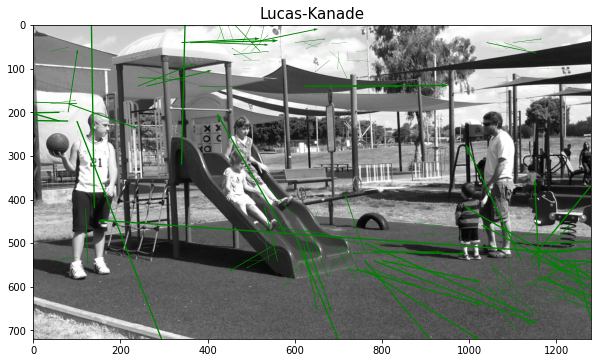

In [ ]:
OF_plot_results(U, V, im1)

**B3. Affine_LK_OF**

Use the variant of Lucas-Kanade with affine motion instead of translation.
See slides - class 7 slides 73-75.

The input and output is the same as in **B1**.


In [ ]:


def affine_LK_OF(video, nf1, nf2, sigma_S, sigma_R):
    
    images = get_video_images(video)
    
    image1 = images[nf1]
    image2 = images[nf2]
    
    mask_x, mask_y = Deriv_Gauss_xy(sigma_S, sigma_S * 4)
    
    mask_t = np.ones((2,2))
    
    fx = convolve2d(image1,  mask_x, mode = 'same') 
    fy = convolve2d(image1,  mask_y, mode = 'same')
    ft = convolve2d(image2,  mask_t, mode = 'same') - convolve2d(image1, mask_t, mode = 'same')  
    
    U, V = get_affine_uv(fx, fy, ft, sigma_R)
    
    return [U, V, image1, image2]

    
    
def get_affine_uv(fx, fy, ft, sigma_R, window_size=43):

    rows, columns = fx.shape
    pad = window_size // 2
    U = np.zeros((fx.shape[0], fx.shape[1]))
    V = np.zeros((fx.shape[0], fx.shape[1]))

    mask_size_R = sigma_R * 4
    G = get_gaussian_kernel(sigma_R, mask_size_R, '', 'normal')

    masked_x = convolve2d(np.square(fx), G, mode='same')
    masked_y = convolve2d(np.square(fy), G, mode='same')


    for i in range(pad, fx.shape[0] - pad):
        for j in range(pad, fx.shape[1] - pad):

            x = fx[i - pad:i + pad + 1, j - pad:j + pad + 1].flatten()
            y = fy[i - pad:i + pad + 1, j - pad:j + pad + 1].flatten()

            maskedx_i = masked_x[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten()
            maskedx_ix = masked_x[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten() * x
            maskedx_iy = masked_x[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten() * y

            maskedy_i = masked_y[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten()
            maskedy_ix = masked_y[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten() * x
            maskedy_iy = masked_y[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten() * y

            ft_i = ft[i - pad: i + pad + 1, j - pad: j + pad + 1].flatten()

            B = np.vstack((maskedx_i, maskedx_ix, maskedx_iy, maskedy_i, maskedy_ix, maskedy_iy)).T

            b = np.reshape(ft_i, (ft_i.shape[0], 1))
            C = np.matmul(B.T, B)

            if np.linalg.matrix_rank(C, 0.5) == 6:
                res = np.matmul(np.linalg.pinv(B), b)
                U[i, j] = res[0] + j * res[1] + res[2] * i
                V[i, j] = res[3] + j * res[4] + res[5] * i

    return U, V


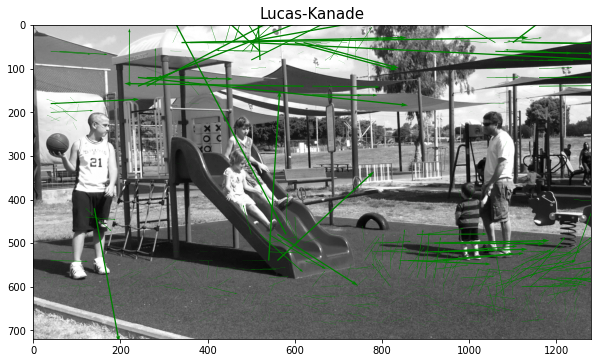

In [ ]:
U, V, im1, _ = affine_LK_OF(video_file_name, 50, 52, 1.0, 1.0)
OF_plot_results(U, V, im1)

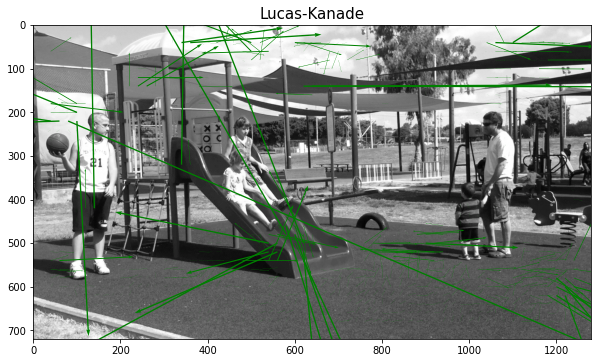

In [ ]:
U, V, im1, _ = affine_LK_OF(video_file_name, 50, 62, 1.0, 1.0)
OF_plot_results(U, V, im1)

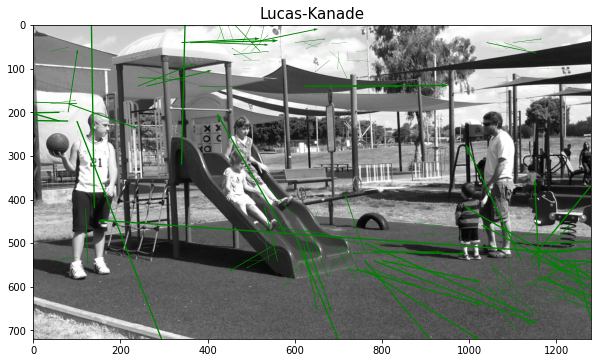

In [ ]:
U, V, im1, _ = affine_LK_OF(video_file_name, 50, 82, 1.0, 1.0)
OF_plot_results(U, V, im1)

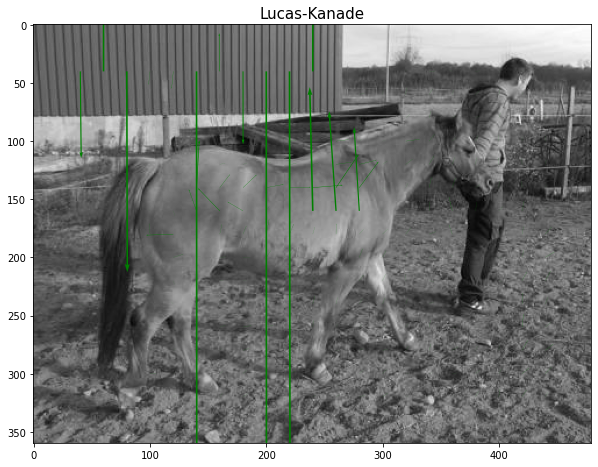

In [ ]:

U, V, im1, _ = affine_LK_OF(moving_camera_file, 50, 52, 1.0, 1.0)
OF_plot_results(U, V, im1)


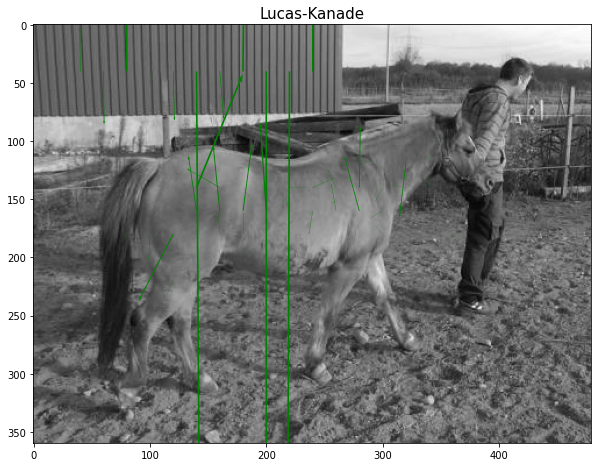

In [ ]:
U, V, im1, _ = affine_LK_OF(moving_camera_file, 50, 62, 1.0, 1.0)
OF_plot_results(U, V, im1)

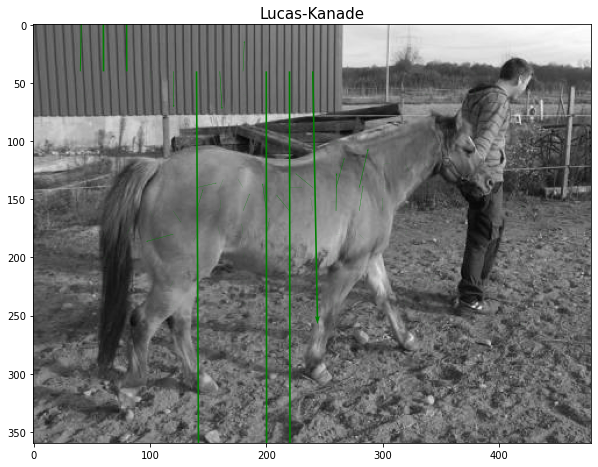

In [ ]:
U, V, im1, _ = affine_LK_OF(moving_camera_file, 50, 82, 1.0, 1.0)
OF_plot_results(U, V, im1)

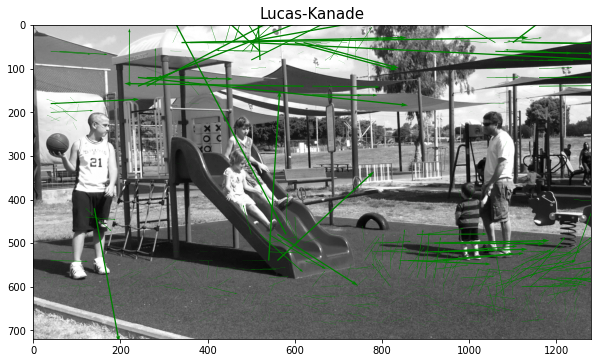

In [ ]:

U, V, im1, _ = affine_LK_OF(video_file_name, 50, 52, 1.0, 1.0)
OF_plot_results(U, V, im1)


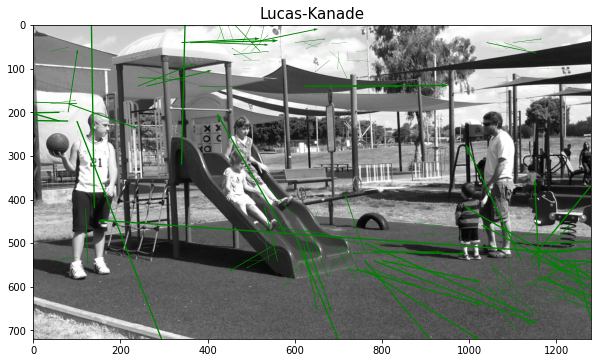

In [ ]:

U, V, im1, _ = affine_LK_OF(video_file_name, 50, 82, 1.0, 1.0)
OF_plot_results(U, V, im1)


**B4. Apply and Discuss:**

Run the LK_OF on two videos, one with a static camera and the other with a moving camera.
Play with the frames chosen from each video, the algorithm parameters, and  the distance between nf1 and nf2.

**Answer:**
1. The disparity you compute in HW2 were integers while the OF is not necessarily integer. Expalin why. 
2. Explain theoretically for which regions the LK_OF is expected to give good results and for which it does not.
3. Demonstrate your answer to (2) by displaying the results of OF overlaid im1  (Quiver overlayed im1), and mark good and bad results.
4. When two OF vectors have the same magnitude, are they necessarily corresponds to 3D points that moves at the same speed?
5. Given the results of OF computation, suggest a method for quantitative evaluation, when the ground truth is not available. 


<b><b><b><b>My Answers <b><b><b>

1. because we divide by time. so although we work with integers like number of shifting pixel
when we divide by time we can get non integers values.

2. since its based on assumptions it will work well when the case fit to the assumptions:
  2.1 nebeher pixels of the same surface have the same motion
  2.2 motion between frames is small.
  The Lucas–Kanade method assumes that the displacement of the image contents between two nearby instants (frames) is small and approximately constant within a neighborhood of the point {\displaystyle p}p under consideration
  2.3 intensity of pixels arouned point we track in some frame should be similary to to the intensity around this pixel
    in the next frame.
  2.4 small motion in local window.

3. see image below. 
   sliding kids move fast we they are not caught well but the father and child and the teenager move slow so 
    they are caught well.

4. No, consider two points with diffrent length to the camera one close and one far.
   they can have the same magnitude vector if they passed similar distance but 
   the point tthat moved from more far distance did it faster 
5. We can compare output of close images. like x,x+2 to x and x+3 etc. 


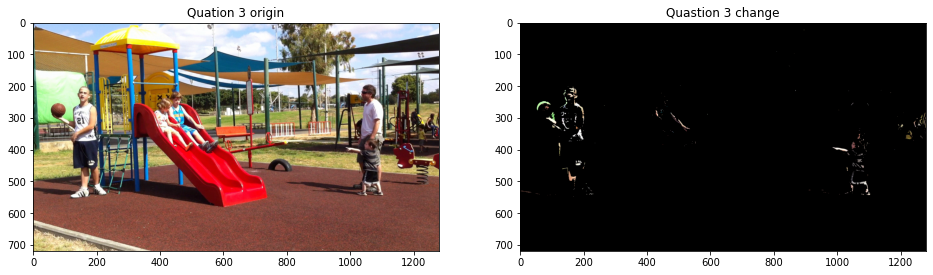

In [ ]:
plot_images(v_origin[10],  "Quation 3 origin", v_foreground[10], "Quastion 3 change")    